# K-Nearest Neighbors from Scratch

- In this project, we are going to build kNN algorithm from scratch and implement the classifier on the Fashion MNIST dataset.

Please note that:
- kNN classifier simply memorizes all of our training data.
- kNN classifier compared each test image with all training image by calculating the Euclidean distances between them. 
** 2 diff methods 
- kNN classifier comes up with a prediction using majority vote.

### Import Libraries

In [1]:
import os 
import time
import torch
import random
import statistics
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from torchvision.utils import make_grid
import torchvision.transforms as transforms
from torchvision.datasets import FashionMNIST

plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['font.size'] = 16

### Import Datasets 

In [2]:
# Import dataset from PyTorch module - torchvision.datasets

train_data = FashionMNIST(root='./data', download=True, train=True, transform=transforms.Compose([transforms.ToTensor()]))
test_data  = FashionMNIST(root='./data', train=False, transform=transforms.Compose([transforms.ToTensor()]))

In [3]:
# Extract data and labels from the FashionMNIST dataset object

def extract_data(dataset):
    """
    Extract the data and labels from the FashionMNIST dataset object.
    
    Input:
    - dataset: A torchvision.datasets.FashionMNIST object
    
    Returns:
    - x: float32 tensor of shape (N, 28, 28)
    - y: int64 tensor of shape (N,)
    """
    
    x = dataset.data.type(torch.float32).div_(255)
    y = dataset.targets
    
    return x, y

In [4]:
x_train, y_train = extract_data(train_data)
x_test, y_test = extract_data(test_data)

In [5]:
print('Training set --   ', )
print('  Data shape   : ', x_train.shape)
print('  Labels shape : ', y_train.shape , "\n")
print('Test set     --   ')
print('  Data shape   : ', x_test.shape)
print('  Labels shape : ', y_test.shape)

Training set --   
  Data shape   :  torch.Size([60000, 28, 28])
  Labels shape :  torch.Size([60000]) 

Test set     --   
  Data shape   :  torch.Size([10000, 28, 28])
  Labels shape :  torch.Size([10000])


### EDA - Plot Training Images 

In [6]:
classes = ['t-shirt/top', 'trousers', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

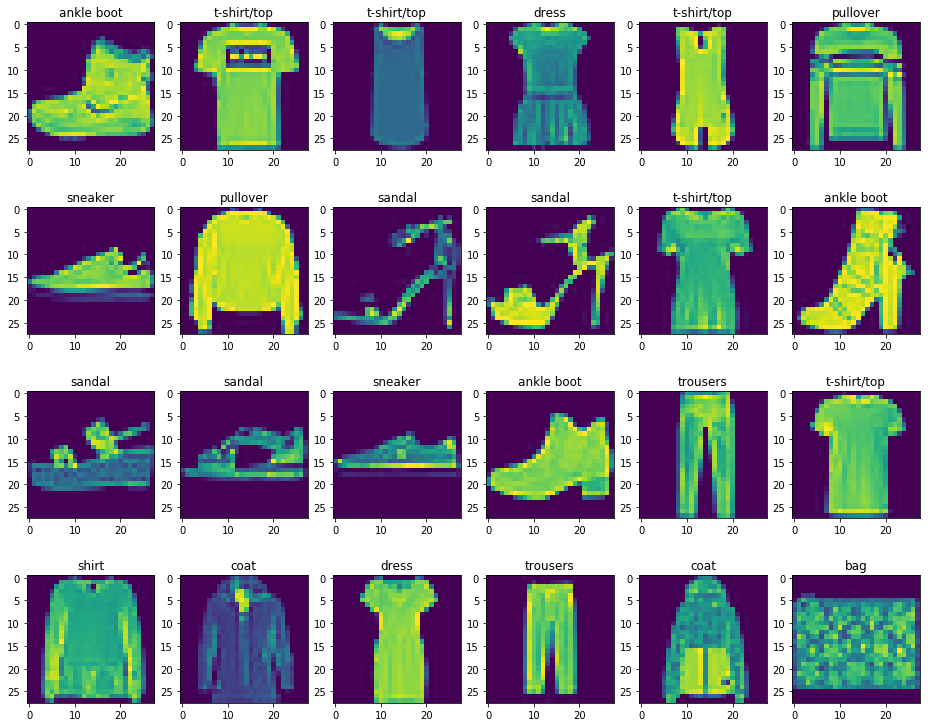

In [7]:
plt.figure(0, figsize=(16, 13))
ctr = 0
for i in range(24):
    ctr += 1
    # define subplot
    plt.subplot(4,6, ctr, title=classes[y_train[i]])
    # plot raw pixel data
    plt.imshow(x_train[i])
# show the figure
plt.show()

### Distance Calculation (Squared Euclidean)

<br>
<img src="euclidean_dist.png" width="400" height="200">
<br><br>

- In the picture above, we have shown two different formulas for the distance calculation. We are going to apply both and compare the difference.

### Version 1: Distance Calculation - Broadcast - One Loop

In [8]:
def dist_calc_version_1(x_train, x_test):
    
    num_train, num_test = x_train.shape[0], x_test.shape[0]
    distance_matrix = torch.zeros(num_train, num_test)
    
    train_flat = x_train.reshape(num_train, x_train.shape[1] * x_train.shape[2])
    test_flat = x_test.reshape(num_test, x_test.shape[1] * x_test.shape[2])
    
    for i in range(num_train):
        train_slice = train_flat[i, :].clone()
        inner_dist = torch.pow((train_slice - test_flat), 2)
        inner_dist = inner_dist.sum(dim=1)
        inner_dist = torch.sqrt(inner_dist)
        distance_matrix[i, :] = inner_dist.clone()
    
    return distance_matrix

In [9]:
start_time = time.time()
dist_1 = dist_calc_version_1(x_train, x_test)
time_diff_1 = time.time() - start_time
print('One loop version took %.2f seconds' % (time_diff_1))

One loop version took 1821.92 seconds


### Version 2: Distance Calculation - Vectorization

In [10]:
def dist_calc_version_2(x_train, x_test):
    
    num_train, num_test = x_train.shape[0], x_test.shape[0]
    distance_matrix = torch.zeros(num_train, num_test)
    
    train_flat = x_train.reshape(num_train, x_train.shape[1] * x_train.shape[2])
    test_flat = x_test.reshape(num_test, x_test.shape[1] * x_test.shape[2])
    
    train_2 = torch.sum((train_flat**2), dim = 1)
    test_2 = torch.sum((test_flat**2), dim = 1)
    
    distance_matrix = torch.sqrt(torch.unsqueeze(train_2, 1) + test_2 - (2*torch.matmul(train_flat, test_flat.t())))
    
    return distance_matrix

In [11]:
start_time = time.time()
dist_2 = dist_calc_version_2(x_train, x_test)
time_diff_2 = time.time() - start_time
print('Vectorized version took %.2f seconds' % (time_diff_2))

Vectorized version took 187.13 seconds


In [16]:
print('Vectorized version is %.2f times faster' % (time_diff_1 / time_diff_2))

Vectorized version is 9.74 times faster


### Labels Prediction

In [13]:
def predict_labels(dists, y_train, k=1):
    num_train, num_test = dists.shape
    y_pred = torch.zeros(num_test, dtype=torch.int64)
    dists = dists.t()
    for i in range(num_test):
        k_neighbors = torch.zeros(1, k, dtype=torch.int)
        k_neighbors = y_train[torch.topk(dists[i,:], k, largest=False, sorted=True)[1]]
        k_neighbors = k_neighbors.tolist()
        y_pred[i] = torch.tensor([Counter(k_neighbors).most_common(1)[0][0]], dtype=torch.int)
    return y_pred

### kNN Classifier

In [14]:
class KnnClassifier:
    def __init__(self, x_train, y_train, x_test, y_test):
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
    
    def predict(self, k=1):
        distance = dist_calc_version_2(self.x_train, self.x_test)
        y_test_pred = predict_labels(distance, self.y_train, k=k)
        return y_test_pred
    
    def check_accuracy(self, k=1):
        y_test_pred = self.predict(k)
        num_samples = self.x_test.shape[0]
        num_correct = (self.y_test == y_test_pred).sum().item()
        accuracy = 100.0 * num_correct / num_samples
        msg = (f'Got {num_correct} / {num_samples} correct; 'f'accuracy is {accuracy:.2f}%')
        return msg

In [15]:
classifier = KnnClassifier(x_train, y_train, x_test, y_test)
print("When k = 1:")
print(classifier.check_accuracy(k=1), "\n")
print("When k = 3:")
print(classifier.check_accuracy(k=3), "\n")
print("When k = 6:")
print(classifier.check_accuracy(k=6), "\n")

When k = 1:
Got 8497 / 10000 correct; accuracy is 84.97% 

When k = 3:
Got 8556 / 10000 correct; accuracy is 85.56% 

When k = 6:
Got 8570 / 10000 correct; accuracy is 85.70% 

